In [1]:
import numpy as np
from utils import *

import keras.utils
from keras import backend as K
from keras.datasets import mnist
from keras.models import save_model,load_model,Model
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, UpSampling2D, AveragePooling2D, MaxPooling2D, Dense,Input, Dropout
from keras.layers import LeakyReLU,Reshape,BatchNormalization, Flatten
from keras.models import save_model
from tempfile import TemporaryFile
import tensorflow as tf
import pickle
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython import display
import time
from sklearn.mixture import GaussianMixture
import umap
from copy import deepcopy
from PIL import Image
from sklearn.cluster import KMeans

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# ! pip install --user umap-learn
# ! pip uninstall --user keras
# ! pip install --user keras==2.1.6
# ! pip install --user matplotlib
# ! pip install --user np_utils
#! pip install --user  Pillow

In [5]:
zdim=10 # This is the dimension of intermediate latent variable 
epochs = 6000
epochstep = epochs/100
nofclasses=10
batchsize=200 
nofprojections = 100

## Data Generation

In [6]:
#Read MNIST

(x_train,y_train),(x_test,y_test)=mnist.load_data()
dataY_train=np.expand_dims(x_train.astype('float32')/255.,3)
dataY_test=np.expand_dims(x_test.astype('float32')/255.,3)

labelY_train = keras.utils.to_categorical(y_train, nofclasses)
labelY_test = keras.utils.to_categorical(y_test, nofclasses)

In [7]:
numdataTrain = labelY_train.shape[0]
numdataTest = labelY_test.shape[0]

dataY_train1 = np.reshape(dataY_train,[numdataTrain,28*28]) 
dataY_test1 = np.reshape(dataY_test,[numdataTest,28*28]) 

In [8]:
import os
cwd = os.getcwd()

In [9]:
USPSMat  = []
USPSTar  = []
curPath  = r'/nas/home/mrostami/NeurIPS2020/USPSDataset/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j) 
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            tempim = np.array(img.getdata())
            tempim = np.reshape(tempim,[28,28])
            imgdata = ((255-tempim).astype(float))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

In [10]:
dataX_train1 = np.array(USPSMat)
USPSTar = np.array(USPSTar)
labelX_train = keras.utils.to_categorical(USPSTar, nofclasses)

dataX_train = np.zeros([len(USPSMat),28,28,1])
for i in range(len(USPSMat)):
    dataX_train[i,:,:,0] = USPSMat[i]

In [11]:
USPSMattest  = []
USPSTartest  = []
curPathtest  = r'/nas/home/mrostami/NeurIPS2020/USPSDataset/Test'
savedImgtest = []

curFolderPathtest = curPathtest 
imgs =  os.listdir(curFolderPathtest)
for img in imgs:
    curImg = curFolderPathtest+'/'+img 
    if curImg[-3:] == 'png':
        imgt = Image.open(curImg,'r')
        imgt = imgt.resize((28, 28))
        savedImg = imgt
        lab =9- int(int(img[-8:-4])/150)        
        tempim = np.array(imgt.getdata())
        tempim = np.reshape(tempim,[28,28])
        imgdata = ((255-tempim).astype(float))/255        
        USPSMattest.append(imgdata)
        USPSTartest.append(lab)

In [12]:
dataX_test1 = np.array(USPSMattest)
USPSTartest = np.array(USPSTartest)
labelX_test = keras.utils.to_categorical(USPSTartest, nofclasses)


dataX_test = np.zeros([len(USPSMattest),28,28,1])
for i in range(len(USPSMattest)):
    dataX_test[i,:,:,0] = USPSMattest[i]

In [13]:
iii = 261
np.argmax(labelY_test[iii,:])

5

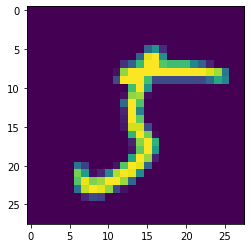

In [14]:
plt.imshow(dataY_test[iii,:,:,0])

In [15]:
iii = 310
np.argmax(labelX_train[iii,:])

0

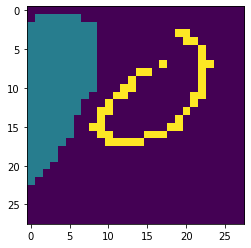

In [16]:
trainim = np.reshape(dataX_train1[iii,:],(28,28))
plt.imshow(trainim)

###  X is input and Z the embedding space

In [17]:
imgX = Input(shape=(28, 28, 1), name="input_img")   
labelX=K.placeholder(shape=(None,nofclasses),dtype='float32') 

In [18]:
# classifier = load_model(filepath='classifierEXT.h5')
# encoderX = load_model(filepath='encoderXEXT.h5')

## Encoder, Decoder and Classifier NN

In [19]:
def ClassifierNN(imgX,nofclasses):
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(imgX)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='block3_pool')(x)
    '''
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='block4_pool')(x)
    # Block 5
    x = Conv2D(512, (2, 2), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (2, 2), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (2, 2), activation='relu', padding='valid', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    '''
    # Top layers
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)




    embed = Dense(nofclasses, activation='relu')(x)
    encoderX = Model(imgX, embed)

    return encoderX

    


In [20]:
encoderX = ClassifierNN(imgX,nofclasses)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
def    classifierNN(nofclasses):
    yin =  Input(shape=( nofclasses,) )

    probX = Dense(nofclasses, activation='softmax')(yin)


    classifier=Model(inputs=[yin],outputs=[probX])
    return classifier


In [22]:
classifier = classifierNN(nofclasses)

# Training on Task 1

In [23]:

discriminationLoss=K.mean(K.categorical_crossentropy(labelX,classifier(encoderX(imgX)))) 

params=encoderX.weights  + classifier.weights  

myLoss = discriminationLoss

opt = Adam(lr=1e-4) # very important
updates = opt.get_updates(myLoss,params)
train = K.function(inputs=[imgX,labelX],outputs=[discriminationLoss],updates=updates)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [24]:
print(keras.__version__) # working version: 2.1.6

2.1.6


In [25]:
print(tf.__version__) # working version: 1.15.0

1.15.0


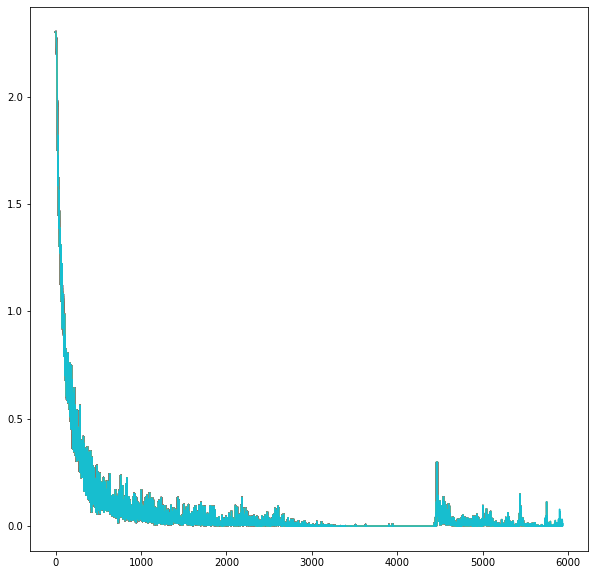

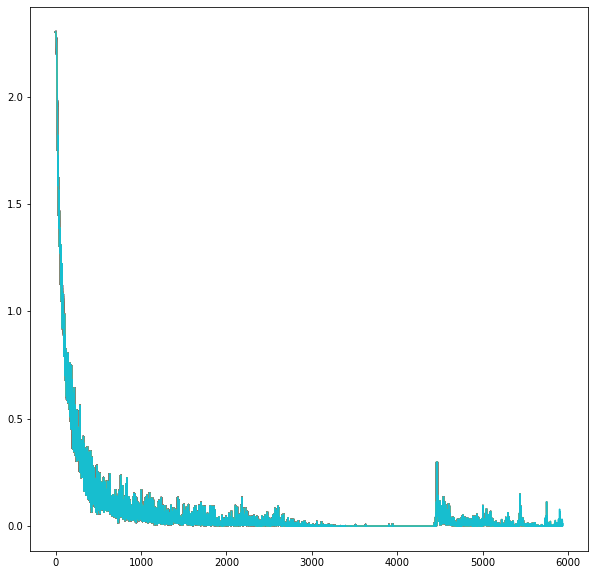

In [26]:
loss = []
fig,ax=plt.subplots(1,figsize=(10,10))

for itr in range(epochs):
    indTrainDataX,trainLabelX=batchGenerator(labelX_train,batchsize,nofclasses=10)
    trainDataX=dataX_train[indTrainDataX,...]
    


    loss.append(train(inputs=[trainDataX, trainLabelX ]))
     
    if itr%epochstep==0:
        ax.plot(np.asarray(loss))
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(1e-3) 
        
        
        
        


In [27]:
perd_label_X = classifier.predict(encoderX.predict(dataX_test))
print(100*float(sum(1*(np.argmax(perd_label_X,axis=1)==np.argmax(np.squeeze(labelX_test),axis=1))))/perd_label_X.shape[0])



97.73333333333333


In [28]:
gmmX = encoderX.predict(dataX_train)
gmmY = np.argmax(labelX_train,axis=1)


In [29]:
yper = classifier.predict(encoderX.predict(dataX_train))
yper = np.argmax(yper, axis=1)

In [30]:
gmmX = gmmX[gmmY==yper,:]
gmmY = gmmY[gmmY==yper]

In [31]:
gmmModel =  GaussianMixture(n_components=nofclasses,covariance_type='full', max_iter=300,init_params='kmeans', tol=1e-04) 


In [32]:
gmmModel.fit(gmmX,gmmY)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=300,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.0001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [33]:
gmmModelSingle =  GaussianMixture(n_components=1,covariance_type='full') 

for i in range(nofclasses):
    a= gmmX[gmmY==i,:]
    gmmModelSingle.fit(a)
    gmmModel.weights_[i] = .1 #gmmY[gmmY==i].shape[0]/gmmY.shape[0]
    gmmModel.covariances_[i] = gmmModelSingle.covariances_[0]
    gmmModel.means_[i] = gmmModelSingle.means_[0]
    
    gmmModel.precisions_cholesky_[i] = gmmModelSingle.precisions_cholesky_[0]
    gmmModel.precisions_[i] = gmmModelSingle.precisions_[0]
    
    
    
    
    

# Target Task

In [44]:
imgY = Input(shape=(nofclasses,) )  # adapt this if using `channels_first` image data format
labelY=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot
lamda2=1e-2

theta=K.variable(generateTheta(nofprojections,nofclasses),) 


#discriminationLoss=  K.mean(K.categorical_crossentropy(labelY,classifier(imgY)))

discriminationLoss= K.mean(K.categorical_crossentropy(labelX,classifier(encoderX(imgX))))\
                    + K.mean(K.categorical_crossentropy(labelY,classifier(imgY)))

matchingLoss=sWasserstein(encoderX(imgX),imgY,theta,nclass=nofclasses,Cp=labelX,Cq=labelY,)


myLoss=  lamda2*matchingLoss  + discriminationLoss  


params=encoderX.weights  + classifier.weights  

opt = Adam(lr=1e-4) # very important
updates = opt.get_updates(myLoss,params)
train = K.function(inputs=[imgX,imgY,labelX,labelY,theta],outputs=[lamda2*matchingLoss],updates=updates)

#train = K.function(inputs=[imgX,imgY,labelX,labelY,theta],outputs=[discriminationLoss,lamda2*matchingLoss],updates=updates)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib64/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib64/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib64/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib64/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converti

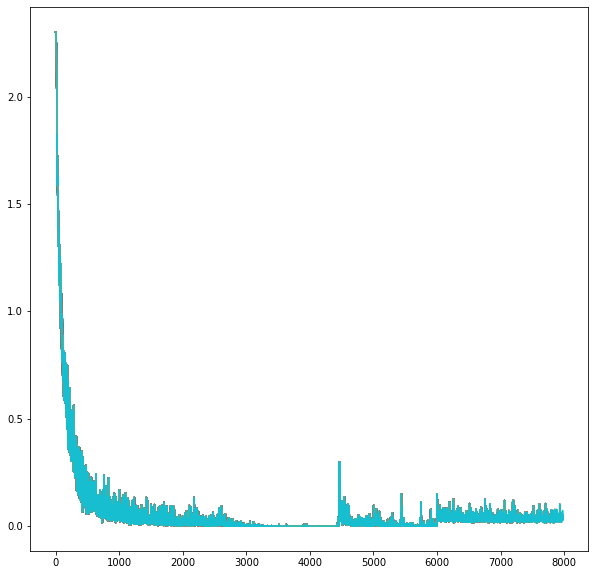

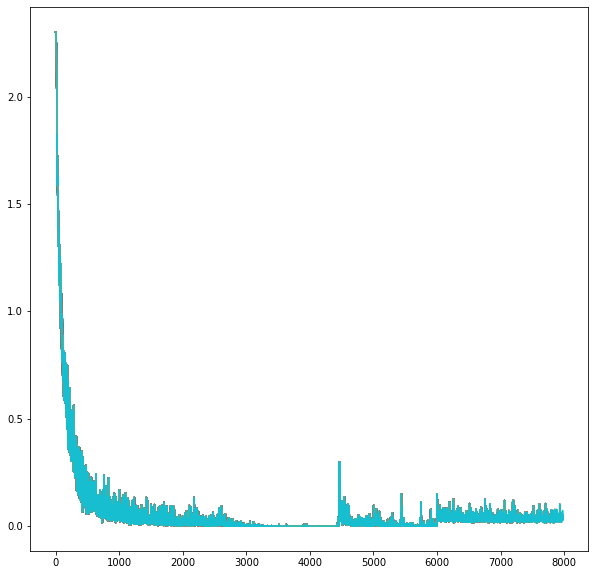

In [45]:
thres = .95
fig,ax=plt.subplots(1,figsize=(10,10))

epochs2 = 20 * 100
epochstep = epochs2/100

for itr in range(epochs2):
    indTrainDataY,trainLabelY=batchGenerator(labelY_train,batchsize,nofclasses=10)
    trainDataY=dataY_train[indTrainDataY,...]
    
    perdLabbatchY = classifier.predict(encoderX.predict(trainDataY))
    problab = np.max(perdLabbatchY,axis=1)
    
    NNN =  1*(problab>thres).sum()
    
    trainLabelY = np.zeros([NNN,nofclasses])
    count = 0
    trainDataYtemp = trainDataY
    trainDataY = np.zeros([NNN,28,28,1])
    for ijk in range(len(problab)):
        if problab[ijk] > thres:
            trainLabelY[count,:] = 1*(perdLabbatchY[ijk,:]>thres) 
            trainDataY[count,:,:,:] = trainDataYtemp[ijk,:,:,:]
            count = count + 1

       
    Yembed1 = np.zeros([NNN,nofclasses])
    Yembed = np.zeros([NNN,nofclasses])
    Yembedlabel = np.zeros([NNN,nofclasses])
    
    Yembed,Yembedlabel1  = gmmModel.sample(n_samples=NNN)
    
    Yembedlabel = keras.utils.to_categorical(Yembedlabel1)   
    
    
    theta_=generateTheta(nofprojections,nofclasses)
    loss.append(train(inputs=[trainDataY,Yembed,trainLabelY,Yembedlabel,theta_]))
     
    if itr%epochstep==0:
        ax.plot(np.asarray(loss))
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(1e-3) 
        
        
        
        


In [47]:
perd_label_Y = classifier.predict(encoderX.predict(dataY_test))
print(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(labelY_test),axis=1))))/perd_label_Y.shape[0])



98.32
